In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from abc import ABC, abstractmethod
from copy import deepcopy

In [2]:
delta = 1e-2

In [3]:
def plot(y, normalize=False, figure=None):
    if figure is None:
        figure = plt.figure(figsize=(18, 4))
    
    if normalize:
        m = np.max(y)
        plt.plot(y/m)
    else:
        plt.plot(y)
    plt.grid(True)
    
    return figure


def plot_pair(x, y, normalize=False, figure=None):
    if figure is None:
        figure = plt.figure(figsize=(18, 4))
    
    if normalize:
        m = np.max(y)
        plt.plot(x, y/m)
    else:
        plt.plot(x, y)
    plt.grid(True)
    
    return figure

# Função abstrata

In [4]:
class Function(ABC):
    def __init__(self):
        super().__init__()

    @abstractmethod
    def apply(self, x):
        pass
    
    def apply_interval(self, l, r, delta=1e-1, translation=0, stretch=1, reflect=False):
        x = np.arange(l, r+delta, delta)        
        y = np.array([y for y in map(self.apply, (x-translation) / stretch)])
        
        if reflect:
            return x, np.flip(y, axis=0)
        else:
            return x, y

In [29]:
class Gaussian(Function):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std
        
    def apply(self, x):
        return (1/(self.std*math.sqrt(2*math.pi))) * math.exp((-1/2) * ((x - self.mean) / self.std) ** 2)
    
    
class Sin(Function):
    def __init__(self):
        super().__init__()
        
    def apply(self, x):
        if x < -math.pi or x > math.pi:
            return 0
        else:
            return math.sin(x)
    
    
class Plato(Function):
    def __init__(self, l, r, height=1):
        super().__init__()
        self.l = l
        self.r = r
        self.height = height
        
    def apply(self, x):
        if self.l <= x and x <= self.r:
            return self.height
        else:
            return 0
        
        
class Rampa(Function):
    def __init__(self, l, r):
        super().__init__()
        self.l = l
        self.r = r
        
    def apply(self, x):
        if self.l <= x and x <= self.r:
            return (x - self.l) / (self.r - self.l)
        else:
            return 0
        
        
class Pulso(Function):
    def __init__(self, k=1):
        super().__init__()
        self.k = k
        
        
    def apply(self, x):
        if abs(x) < delta:
            return self.k
        else:
            return 0
        
class GaussianFirstDerivative(Function):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std
        
    def apply(self, x):
        return -1 * (((x-self.mean) * math.exp(-1 * (x - self.mean)**2 / (2 * self.std**2))) / (math.sqrt(2*math.pi)*(self.std**3)))
    
    
class GaussianSecondDerivative(Function):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std
        
    def apply(self, x):
        a = ((x-self.mean)**2 * math.exp(-1 * (x - self.mean)**2 / (2 * self.std**2))) / (self.std**4)
        b = (math.exp(-1 * (x - self.mean)**2 / (2 * self.std**2))) / (self.std**2)
        c = math.sqrt(2*math.pi) * self.std
        return (a-b) / c
    

### exemplo

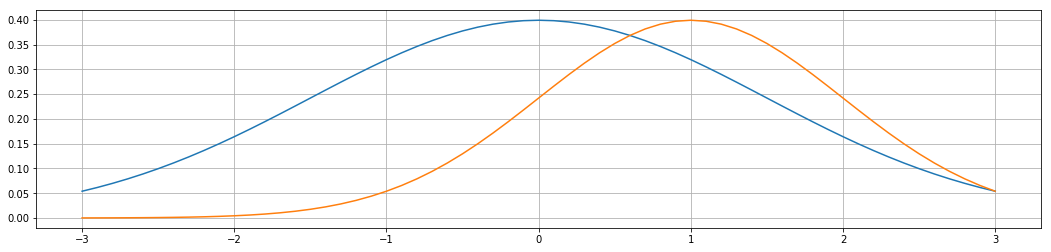

In [6]:
g = Gaussian(std=1, mean=0)

x, y = g.apply_interval(-3, 3, delta=1e-1, translation=0, stretch=1.5)
figure = plot_pair(x, y)

x, y = g.apply_interval(-3, 3, delta=1e-1, translation=1)
_ = plot_pair(x, y, figure=figure)

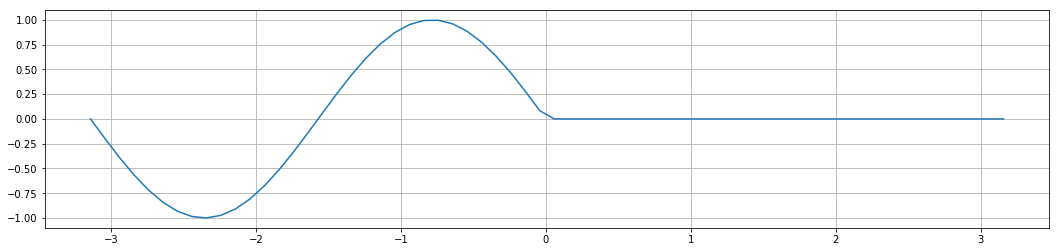

In [7]:
s = Sin()

x, y = s.apply_interval(-math.pi, math.pi, stretch=.5, translation=-math.pi/2)
_ = plot_pair(x, y)

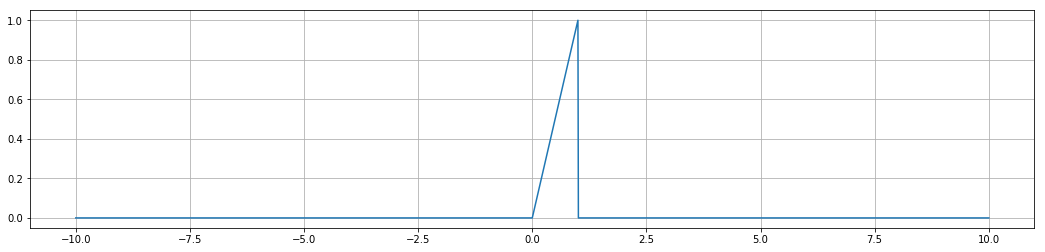

In [8]:
rampa = Rampa(0, 1)

x, y = rampa.apply_interval(-10, 10, delta=1e-2)

_ = plot_pair(x, y)

# Definindo h

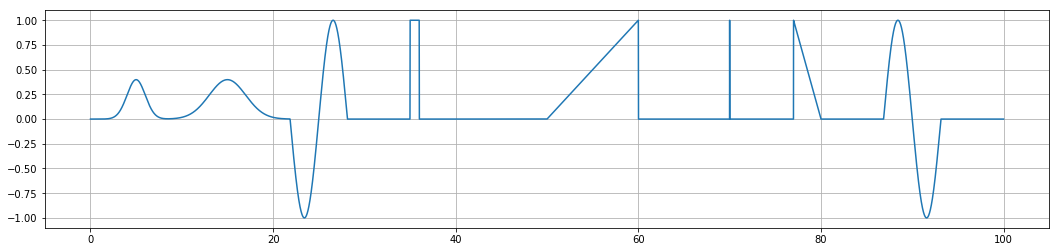

In [9]:
gaussian = Gaussian(mean=0, std=1)
sin = Sin()
plato = Plato(0, 1, 1)
rampa = Rampa(0, 1)
pulso = Pulso()

limit_l = 0
limit_r = 100

x_h, y_gaussian = g.apply_interval(limit_l, limit_r, delta=delta, translation=5)
_, y_gaussian2 = g.apply_interval(limit_l, limit_r, delta=delta, translation=15, stretch=2)
_, y_sin = sin.apply_interval(limit_l, limit_r, delta=delta, translation=25)
_, y_plato = plato.apply_interval(limit_l, limit_r, delta=delta, translation=35)
_, y_rampa = rampa.apply_interval(limit_l, limit_r, delta=delta, translation=50, stretch=10)
_, y_pulso = pulso.apply_interval(limit_l, limit_r, delta=delta, translation=70)

_, y_sin2 = sin.apply_interval(limit_l, limit_r, delta=delta, translation=10, reflect=True)
_, y_rampa2 = rampa.apply_interval(limit_l, limit_r, delta=delta, translation=20, stretch=3, reflect=True)


h = y_gaussian + y_gaussian2 + y_sin + y_plato + y_rampa + y_pulso + y_sin2 + y_rampa2
figure = plot_pair(x_h, h)

# Correlação

In [10]:
def correlacao(f: np.ndarray, g: np.ndarray):
    n = f.shape[0]
    m = g.shape[0]
    
    a = 0
    b = n-1
    c = 0
    d = m-1
    
    z = np.zeros(n-1)
    g = np.concatenate([z, g, z], axis=0)
    g = np.conjugate(g)
    
    cc = c - n + 1
    dd = d + n - 1
    
    if str(f.dtype).startswith('complex') or str(g.dtype).startswith('complex'):
        corr = np.zeros(n+m-1, dtype=np.complex)
    else:
        corr = np.zeros(n+m-1)
    
    for k in range(c-b, d-a+1):
        aux = 0
        for i in range(a, b+1):
            aux += f[i-a] * g[k+i-cc]
        corr[k-c+b] = aux
        
    return corr


def correlacao(f, g):
    return np.correlate(f, g, mode='full')

In [11]:
u = np.array([1+3j, 2, 3, 4, 6], dtype=np.complex)
v = np.array([1, 2], dtype=np.complex)

print(correlacao(u, v))

[ 2.+6.j  5.+3.j  8.+0.j 11.+0.j 16.+0.j  6.+0.j]


In [12]:
print(np.correlate(u, v, mode='full'))

[ 2.+6.j  5.+3.j  8.+0.j 11.+0.j 16.+0.j  6.+0.j]


# Convolução

In [13]:
def convolution(g: np.ndarray, h: np.ndarray):
    n = g.shape[0]
    m = h.shape[0]
    
    a = 0
    b = n-1
    c = 0
    d = m-1
    
    z = np.zeros(n-1)
    h = np.concatenate([z, h, z], axis=0)
    
    cc = c - n + 1
    dd = d + n - 1
    
    conv = np.zeros(n+m-1)
        
    for k in range(c+a, d+b+1):
        aux = 0
        for i in range(a, b+1):
            aux += g[i-a] * h[k-i-cc]
        conv[k-c-a] = aux
        
    return conv

def convolution(g, h):
    return np.convolve(g, h, mode='same')

In [14]:
u = np.array([1, 2, 3, 4, 6])
v = np.array([1, 2])

print(convolution(u, v))
print(convolution(v, u))

[ 1  4  7 10 14]
[ 1  4  7 10 14]


In [15]:
print(np.convolve(u, v, mode='full'))
print(np.convolve(v, u, mode='full'))

[ 1  4  7 10 14 12]
[ 1  4  7 10 14 12]


In [16]:
print(np.convolve(u, v, mode='valid'))

[ 4  7 10 14]


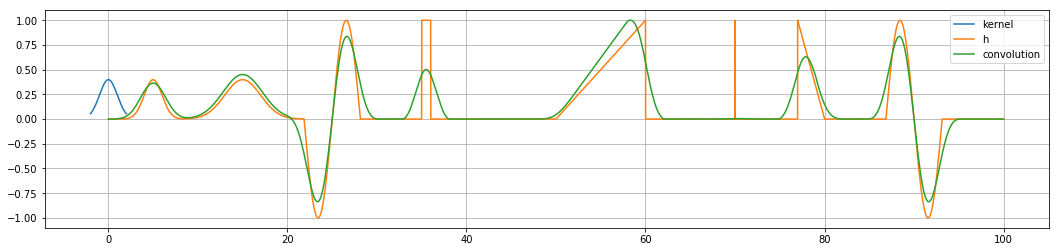

In [17]:
x, g = gaussian.apply_interval(-2, 2, delta=delta)
figure = plot_pair(x, g)

_ = plot_pair(x_h, h, normalize=True, figure=figure)

_ = plot_pair(x_h, convolution(h, g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])

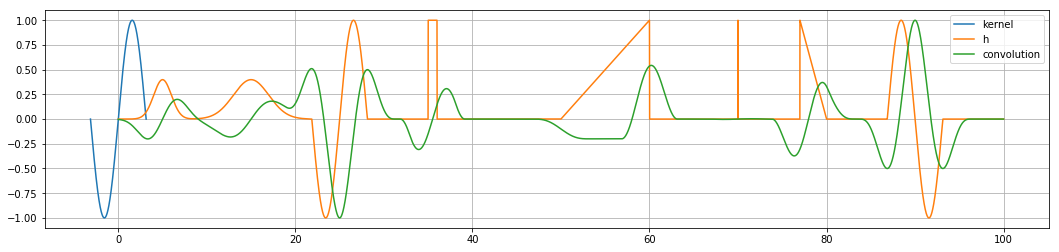

In [18]:
x, g = sin.apply_interval(-math.pi, math.pi, delta=delta)
figure = plot_pair(x, g)

_ = plot_pair(x_h, h, normalize=True, figure=figure)

_ = plot_pair(x_h, convolution(h, g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])

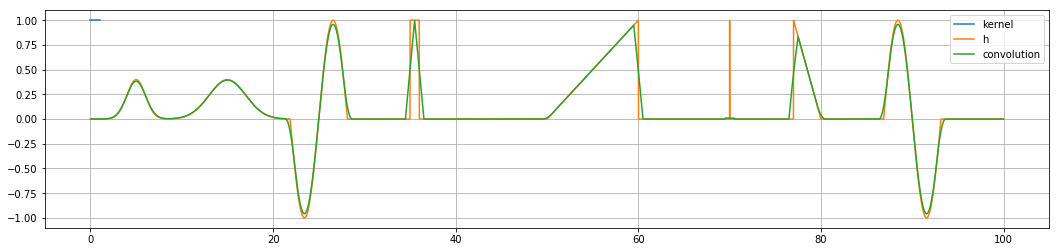

In [19]:
x, g = plato.apply_interval(0, 1, delta=delta)
figure = plot_pair(x, g)

_ = plot_pair(x_h, h, normalize=True, figure=figure)

_ = plot_pair(x_h, convolution(h, g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])

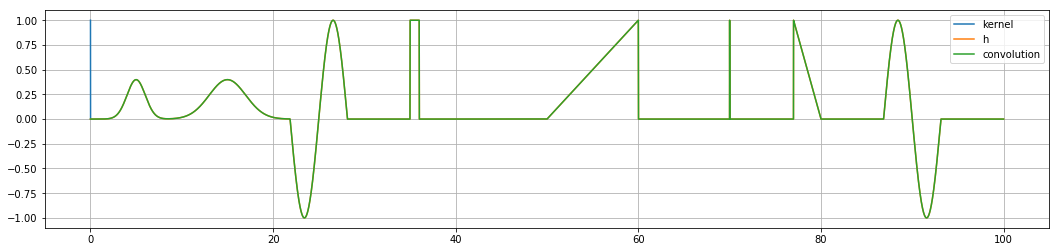

In [20]:
x, g = pulso.apply_interval(0, delta, delta=delta)
figure = plot_pair(x, g)

_ = plot_pair(x_h, h, normalize=True, figure=figure)

_ = plot_pair(x_h, convolution(h, g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])

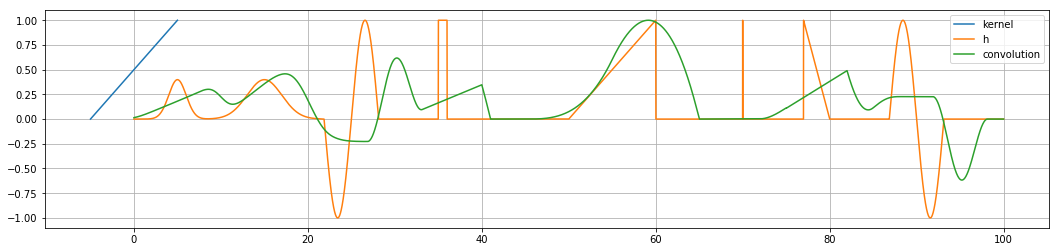

In [21]:
x, g = Rampa(-5, 5).apply_interval(-5, 5, delta=delta, stretch=1)
figure = plot_pair(x, g)

_ = plot_pair(x_h, h, normalize=True, figure=figure)

_ = plot_pair(x_h, convolution(h, g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])

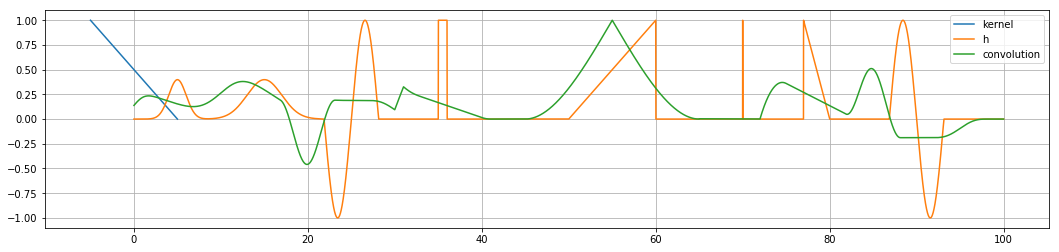

In [22]:
x, g = Rampa(-5, 5).apply_interval(-5, 5, delta=delta, stretch=1, reflect=True)
figure = plot_pair(x, g)

_ = plot_pair(x_h, h, normalize=True, figure=figure)

_ = plot_pair(x_h, convolution(h, g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])

# Pirâmide

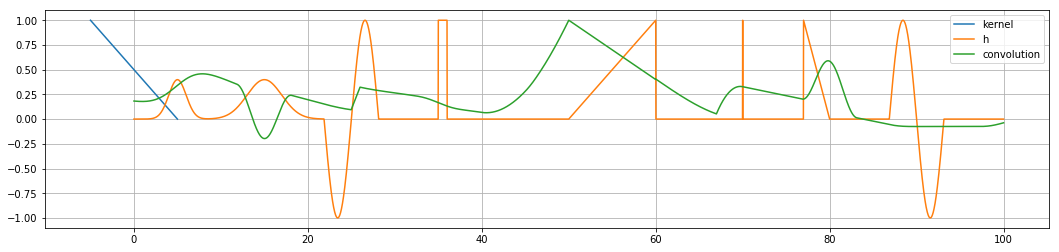

In [23]:
x, g = Rampa(-5, 5).apply_interval(-5, 5, delta=delta, stretch=1, reflect=True)
figure = plot_pair(x, g)

_ = plot_pair(x_h[0::2], h[0::2], normalize=True, figure=figure)

_ = plot_pair(x_h[0::2], convolution(h[0::2], g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])

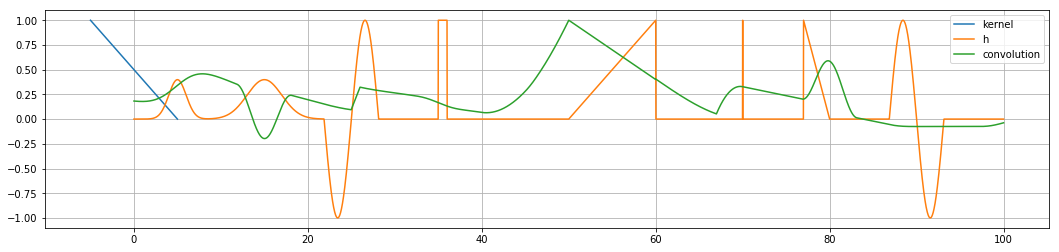

In [24]:
d = 2

x, g = Rampa(-5, 5).apply_interval(-5, 5, delta=delta, stretch=1, reflect=True)
figure = plot_pair(x, g)

_ = plot_pair(x_h[0::d], h[0::d], normalize=True, figure=figure)

_ = plot_pair(x_h[0::d], convolution(h[0::d], g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])

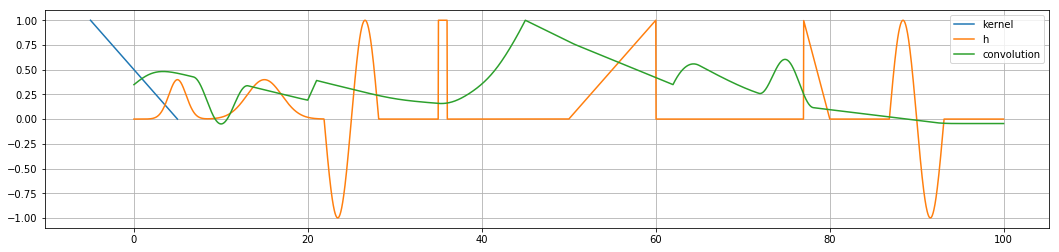

In [25]:
d = 3

x, g = Rampa(-5, 5).apply_interval(-5, 5, delta=delta, stretch=1, reflect=True)
figure = plot_pair(x, g)

_ = plot_pair(x_h[0::d], h[0::d], normalize=True, figure=figure)

_ = plot_pair(x_h[0::d], convolution(h[0::d], g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])

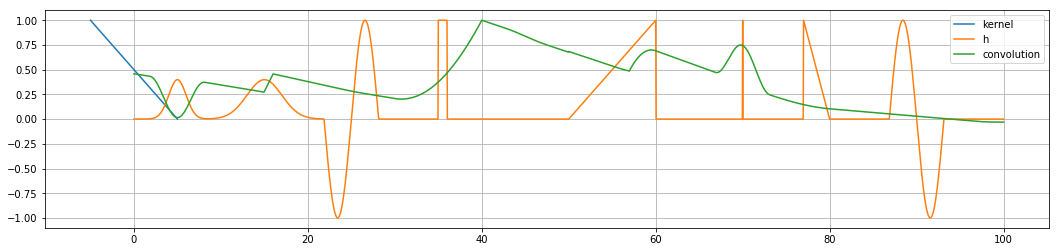

In [26]:
d = 4

x, g = Rampa(-5, 5).apply_interval(-5, 5, delta=delta, stretch=1, reflect=True)
figure = plot_pair(x, g)

_ = plot_pair(x_h[0::d], h[0::d], normalize=True, figure=figure)

_ = plot_pair(x_h[0::d], convolution(h[0::d], g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])

# Derivadas

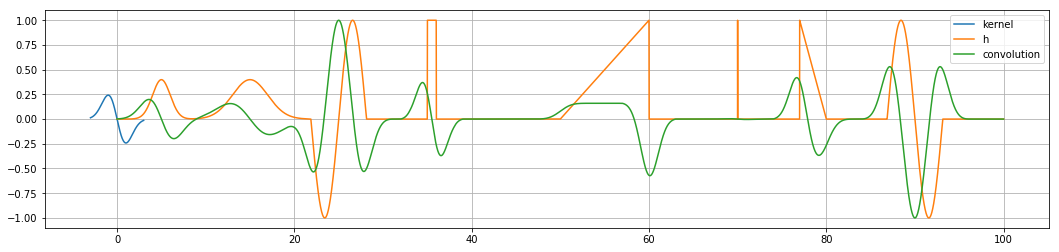

In [33]:
x, g = GaussianFirstDerivative(0, 1).apply_interval(-3, 3, delta=delta, stretch=1)
figure = plot_pair(x, g)

_ = plot_pair(x_h, h, normalize=True, figure=figure)

_ = plot_pair(x_h, convolution(h, g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])

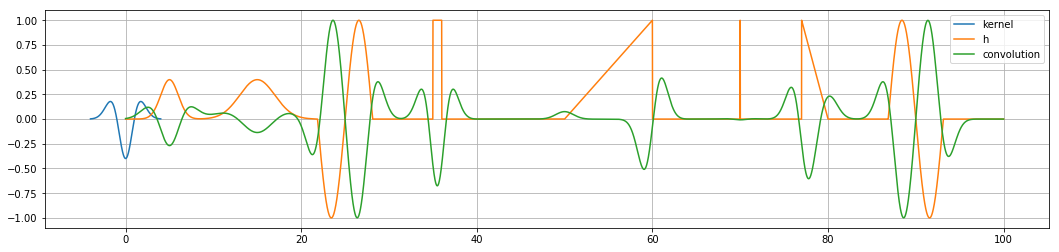

In [35]:
x, g = GaussianSecondDerivative(0, 1).apply_interval(-4, 4, delta=delta, stretch=1)
figure = plot_pair(x, g)

_ = plot_pair(x_h, h, normalize=True, figure=figure)

_ = plot_pair(x_h, convolution(h, g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])

# Noise

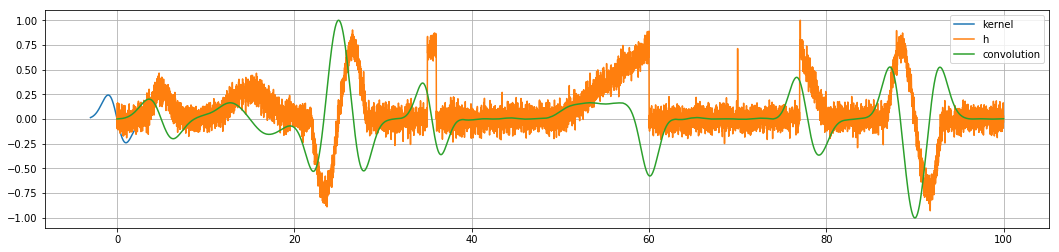

In [38]:
x, g = GaussianFirstDerivative(0, 1).apply_interval(-3, 3, delta=delta, stretch=1)
figure = plot_pair(x, g)

h_noise = h + np.random.normal(loc=0, scale=1e-1, size=h.shape)

_ = plot_pair(x_h, h_noise, normalize=True, figure=figure)

_ = plot_pair(x_h, convolution(h_noise, g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])

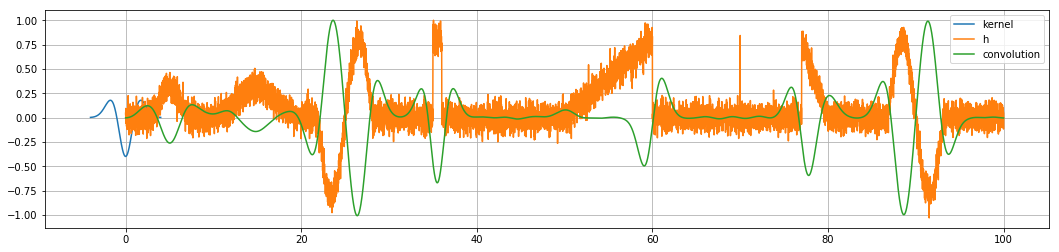

In [39]:
x, g = GaussianSecondDerivative(0, 1).apply_interval(-4, 4, delta=delta, stretch=1)
figure = plot_pair(x, g)

h_noise = h + np.random.normal(loc=0, scale=1e-1, size=h.shape)

_ = plot_pair(x_h, h_noise, normalize=True, figure=figure)

_ = plot_pair(x_h, convolution(h_noise, g), figure=figure, normalize=True)

plt.legend(['kernel', 'h', 'convolution'])